In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_37144/2292707060.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ds_version = "V1_0"
annotations_file = "streetSurfaceVis_v1_0.csv"
pred_file = "effnet_hierarchical_prediction-V1_0_s_1024-20250223_140644.csv"
root_data_path = os.path.join("..", "data", ds_version)
# root_data_path = f"/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/{ds_version}"
data_path = os.path.join(root_data_path, "metadata")
# only_validation = True

In [3]:
pred = pd.DataFrame()

print(f"reading {pred_file}")
pred = pd.read_csv(os.path.join(data_path, pred_file))
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred", "Level_1": "quality_label_pred"}, inplace=True)

quality_pred = pred[pred.Level == "quality"][["image_id", "Prediction", "quality_label_pred", "is_in_validation"]]
quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
idx = type_pred.groupby("image_id")["class_prob"].idxmax()
type_pred = type_pred.loc[idx]
pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")

reading effnet_hierarchical_prediction-V1_0_s_1024-20250223_140644.csv


In [4]:
annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true", "surface_quality": "quality_label_true"}, inplace=True)
annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [17]:
df = pred.join(
    annot[["image_id", "type_true", "quality_label_true", "quality_float_true", "train"]].set_index("image_id"), how="left")

In [18]:
df_test_type = df[~df.train]
df_test_type

,quality_float_pred,quality_label_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_label_true,quality_float_true,train
image_id,,,,,,,,,,
1001609044211988,2.660716,intermediate,0,0.999811,unpaved,0,unpaved,intermediate,3,False
1001729437616660,2.522588,intermediate,0,0.999914,asphalt,0,paving_stones,intermediate,3,False
1003320543995770,1.175360,excellent,0,0.999579,asphalt,0,asphalt,good,2,False
1003492640340054,1.190253,excellent,0,0.999466,asphalt,0,asphalt,good,2,False
10036430943063472,3.300188,intermediate,0,0.999871,sett,0,sett,bad,4,False
...,...,...,...,...,...,...,...,...,...,...
989870525476597,1.933909,good,0,0.999599,asphalt,0,asphalt,good,2,False
992410964895743,3.264969,intermediate,0,0.998107,sett,0,sett,bad,4,False
996532608211964,1.502844,good,0,0.583843,concrete,0,unpaved,intermediate,3,False


In [19]:
df = df[df.train]
df

,quality_float_pred,quality_label_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_label_true,quality_float_true,train
image_id,,,,,,,,,,
1000927687276860,3.019460,intermediate,0,0.998928,concrete,0,concrete,intermediate,3,True
1001349260556407,3.649784,bad,0,0.999996,unpaved,0,unpaved,bad,4,True
1001419624308587,1.737763,good,0,0.958917,asphalt,0,asphalt,good,2,True
1001712924422413,1.165464,excellent,0,0.999813,concrete,0,concrete,excellent,1,True
1001853784055707,0.802269,excellent,0,0.999958,asphalt,0,asphalt,excellent,1,True
...,...,...,...,...,...,...,...,...,...,...
997256148134538,1.089326,excellent,0,0.999769,asphalt,0,asphalt,excellent,1,True
998443217521030,3.646559,bad,0,0.999998,unpaved,0,unpaved,bad,4,True
999340993934138,0.703160,excellent,0,0.999797,paving_stones,0,paving_stones,excellent,1,True


In [20]:
#df.groupby(["type_true", "quality_label_true"]).size()

In [21]:
df_valid_type = df[df.is_in_validation_type == 1]
df_train_type = df[df.is_in_validation_type == 0]
print(df_valid_type.shape)
print(df_train_type.shape)

(1670, 10)
(6676, 10)


In [22]:
# filter by correct type prediction (hierarchical quality depends on type prediction)
df_quality = df[df.type_true == df.type_pred]
df_valid_quality = df_quality[df_quality.is_in_validation_quality == 1]
df_train_quality = df_quality[df_quality.is_in_validation_quality == 0]
print(df_valid_quality.shape)
print(df_train_quality.shape)

(1585, 10)
(6657, 10)


In [23]:
df_test_quality = df_test_type[df_test_type.type_true == df_test_type.type_pred]
df_test_quality

,quality_float_pred,quality_label_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_label_true,quality_float_true,train
image_id,,,,,,,,,,
1001609044211988,2.660716,intermediate,0,0.999811,unpaved,0,unpaved,intermediate,3,False
1003320543995770,1.175360,excellent,0,0.999579,asphalt,0,asphalt,good,2,False
1003492640340054,1.190253,excellent,0,0.999466,asphalt,0,asphalt,good,2,False
10036430943063472,3.300188,intermediate,0,0.999871,sett,0,sett,bad,4,False
1005619040188548,1.226131,excellent,0,0.774072,asphalt,0,asphalt,excellent,1,False
...,...,...,...,...,...,...,...,...,...,...
984996162943315,3.279550,intermediate,0,0.991406,asphalt,0,asphalt,bad,4,False
989870525476597,1.933909,good,0,0.999599,asphalt,0,asphalt,good,2,False
992410964895743,3.264969,intermediate,0,0.998107,sett,0,sett,bad,4,False


## Global measures

In [24]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

#### global measures for type

In [27]:
# all
gm = compute_measures_cat(df.type_true, df.type_pred)
gm_valid = compute_measures_cat(df_valid_type.type_true, df_valid_type.type_pred)
gm_train = compute_measures_cat(df_train_type.type_true, df_train_type.type_pred)
gm_test = compute_measures_cat(df_test_type.type_true, df_test_type.type_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train"), pd.Series(gm_test, name="test")], axis=1).round(2)

,all,validation,train,test
accuracy,0.99,0.95,1.0,0.91


#### global measures for quality

In [28]:
# all
gm = compute_measures_float(df_quality.quality_float_true, df_quality.quality_float_pred)
gm_valid = compute_measures_float(df_valid_quality.quality_float_true, df_valid_quality.quality_float_pred)
gm_train = compute_measures_float(df_train_quality.quality_float_true, df_train_quality.quality_float_pred)
gm_test = compute_measures_float(df_test_quality.quality_float_true, df_test_quality.quality_float_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train"), pd.Series(gm_test, name="test")], axis=1).round(3)

,all,validation,train,test
accuracy,0.808,0.639,0.848,0.602
correlation,0.944,0.869,0.961,0.835
r_square,0.852,0.705,0.887,0.672
mse,0.164,0.329,0.125,0.319
rmse,0.405,0.573,0.353,0.565


## Surface type

In [ ]:
#plt.rcParams.update({'font.size': 14})

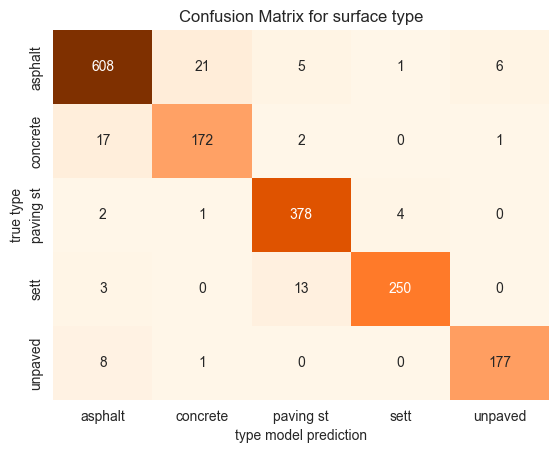

In [46]:
# validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])
cm = confusion_matrix(df_valid_type.type_true, df_valid_type.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

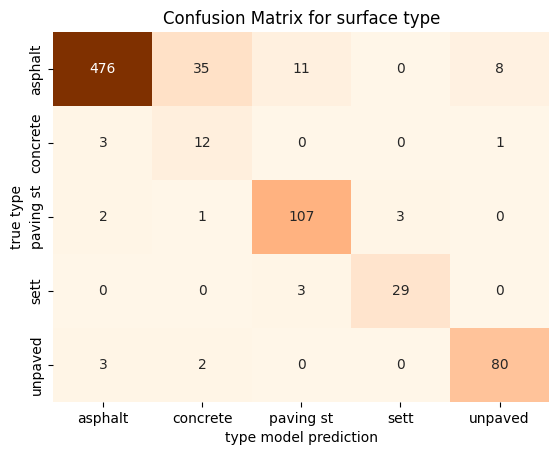

In [ ]:
# test
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])
cm = confusion_matrix(df_test_type.type_true, df_test_type.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

## Measures for quality by surface type

In [30]:
gm_surface = pd.DataFrame()
for surface in df_valid_quality.type_true.unique():
    df_ = df_valid_quality[df_valid_quality.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,unpaved,paving_stones,sett
accuracy,0.62,0.81,0.63,0.55,0.71
correlation,0.79,0.89,0.74,0.70,0.64
r_square,0.57,0.77,0.50,0.21,0.34
mse,0.33,0.19,0.31,0.46,0.24
rmse,0.57,0.44,0.56,0.68,0.49


In [31]:
gm_surface = pd.DataFrame()
for surface in df_test_quality.type_true.unique():
    df_ = df_test_quality[df_test_quality.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,unpaved,asphalt,sett,paving_stones,concrete
accuracy,0.57,0.61,0.69,0.55,0.75
correlation,0.64,0.63,0.73,0.46,0.80
r_square,0.13,0.31,0.18,-0.24,0.63
mse,0.36,0.30,0.26,0.39,0.17
rmse,0.60,0.55,0.51,0.62,0.42


## compare float values

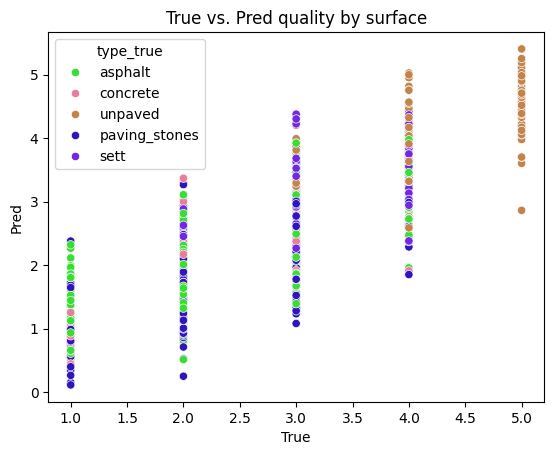

In [32]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df_valid_quality.type_true.unique()}

sns.scatterplot(data=df_valid_quality, x="quality_float_true", y="quality_float_pred", hue="type_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


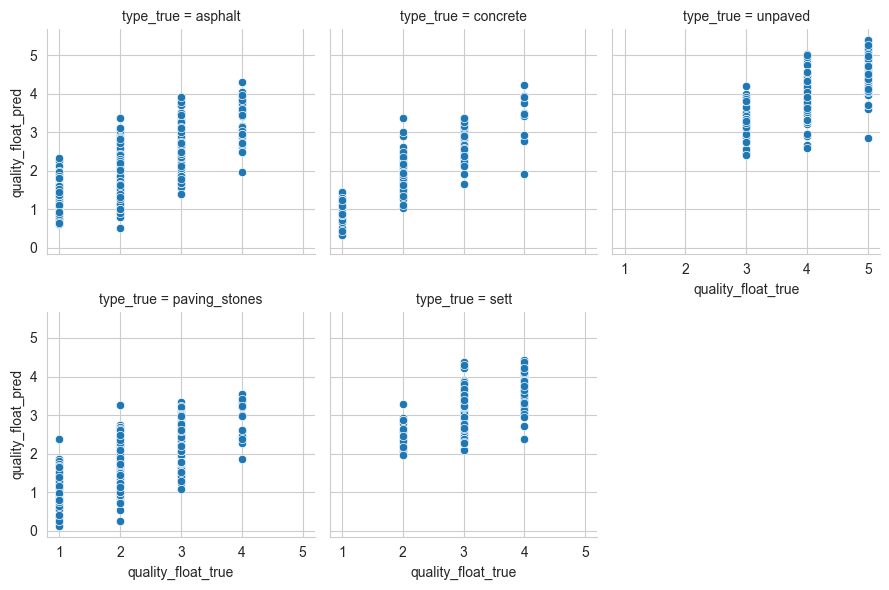

In [33]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [35]:
dev = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred
df_valid_quality.loc[:,"deviation"] = dev

**Overall**

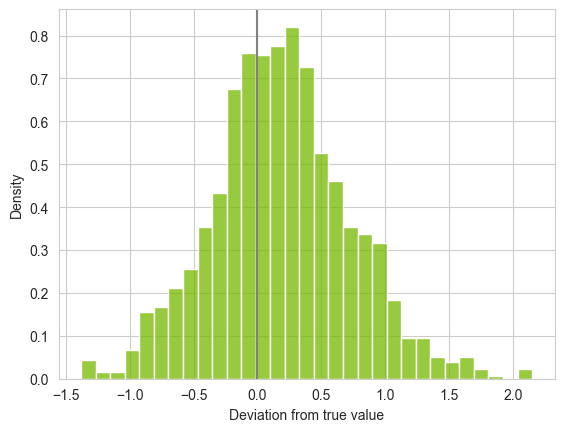

In [36]:
sns.histplot(df_valid_quality, color='#76B900', stat="density", x="deviation")
plt.xlabel("Deviation from true value")
plt.axvline(x=0, color="grey")
plt.savefig("deviation_hist_quality_V1_0.png", transparent=True)
plt.show()


In [37]:
np.mean(df_valid_quality.deviation)

0.18656085298076414

In [38]:
np.std(df_valid_quality.deviation)


0.5421293477800493

In [39]:
(abs(df_valid_quality.deviation) >= 1).value_counts()

deviation
False    1460
True      125
Name: count, dtype: int64

In [40]:
sum(abs(df_valid_quality.deviation) >= 1)/len(df_valid_quality)

0.07886435331230283

**by surface**

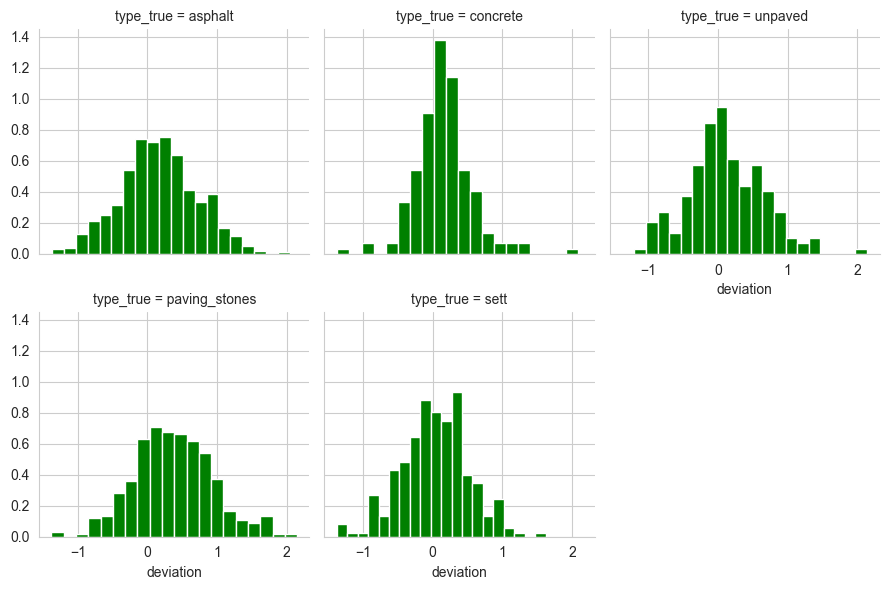

In [41]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

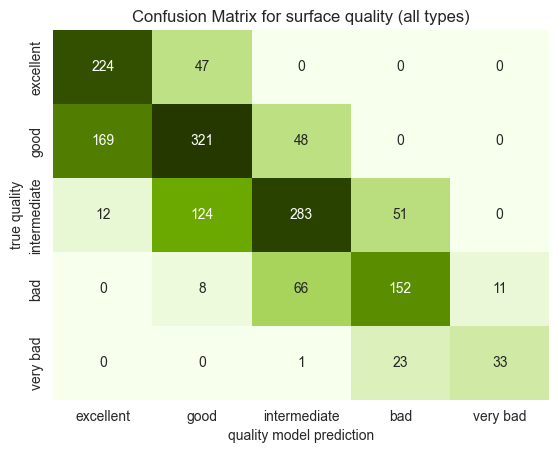

In [42]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_valid_quality.quality_label_true, df_valid_quality.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

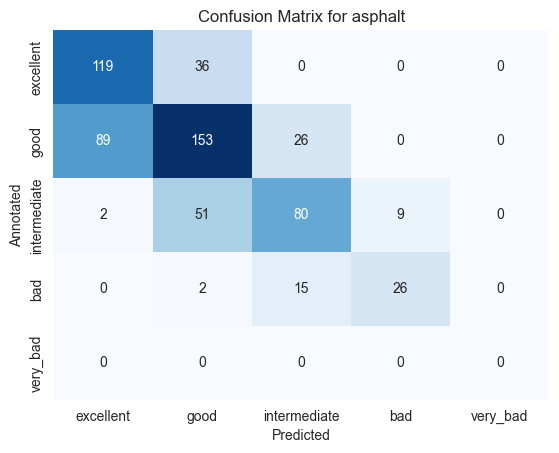

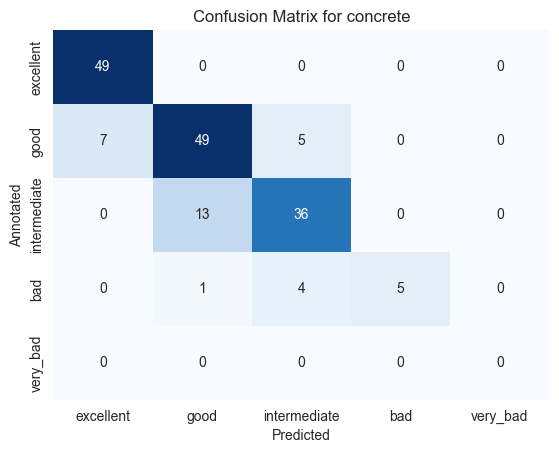

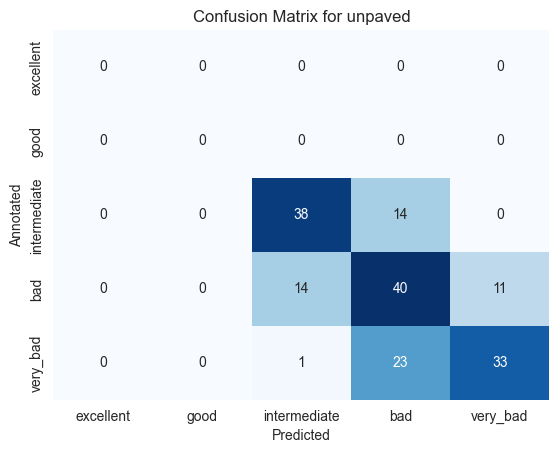

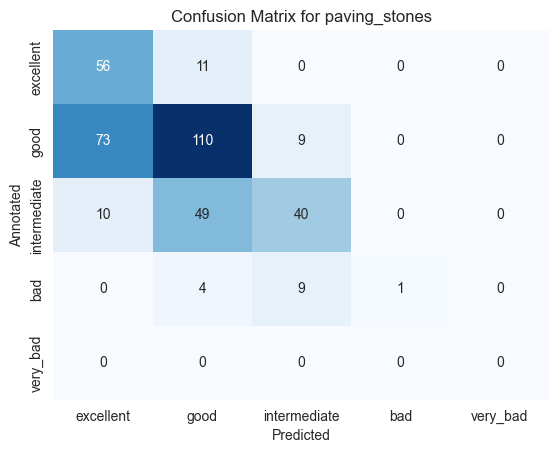

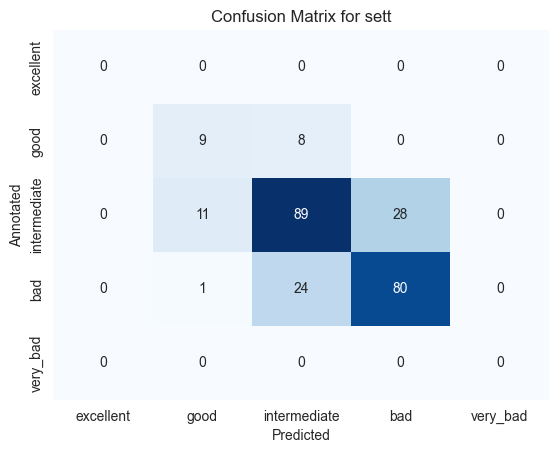

In [43]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df_valid_quality.type_true.unique():
    _df = df_valid_quality[(df_valid_quality.type_true == surface)]
    cm = confusion_matrix(_df.quality_label_true, _df.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()



In [45]:
# Extract predicted and ground truth values
precisions = []
recalls = []
f1scores = []
for class_name in df_valid_type['type_true'].unique():
    _df1 = df_valid_type[df_valid_type['type_pred'] == class_name]
    _df2 = df_valid_type[df_valid_type['type_true'] == class_name]
    class_precision = sum(_df1.type_true == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)
    f1score = 2 * (class_precision * class_recall) / (class_precision + class_recall)
    precisions.append(class_precision)
    recalls.append(class_recall)
    f1scores.append(f1score)

    print(f"Class: {class_name}")
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

print("------------------------")
print("------------------------")

print(f"Average precision: {round(np.mean(precisions), 2)}")
print(f"Average recall: {round(np.mean(recalls), 2)}")
print(f"Average F1-Score: {round(np.mean(f1scores), 2)}")
print(f"Accuracy: {round(sum(df_valid_type.type_true == df_valid_type.type_pred) / len(df_valid_type), 2)}")

Class: asphalt
Count (pred): 638
Count (true): 641
Precision: 0.95
Recall: 0.95
------------------------
Class: concrete
Count (pred): 195
Count (true): 192
Precision: 0.88
Recall: 0.9
------------------------
Class: unpaved
Count (pred): 184
Count (true): 186
Precision: 0.96
Recall: 0.95
------------------------
Class: paving_stones
Count (pred): 398
Count (true): 385
Precision: 0.95
Recall: 0.98
------------------------
Class: sett
Count (pred): 255
Count (true): 266
Precision: 0.98
Recall: 0.94
------------------------
------------------------
------------------------
Average precision: 0.95
Average recall: 0.94
Average F1-Score: 0.94
Accuracy: 0.95
